# Libraries

In [2]:
# Common
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [ ]:
from statsmodels.tsa.seasonal import  MSTL

# Further Analysis

In [6]:
df = pd.read_parquet('post_clean.parquet')

In [7]:
# Because of financial meaning I'll only use the confirmed seats
confirmed_df = df[df["status_id"]=="CONFIRMED"].copy()

# This is to exclude the insurance ancillary
actual_travel_df = confirmed_df[confirmed_df["vehclass_id"]!='insurance'].copy()

## Trend & Seasonality

### By travel date

In [134]:
actual_travel_date_df = actual_travel_df[actual_travel_df['godate'].dt.year.isin([2019,2023])].copy()

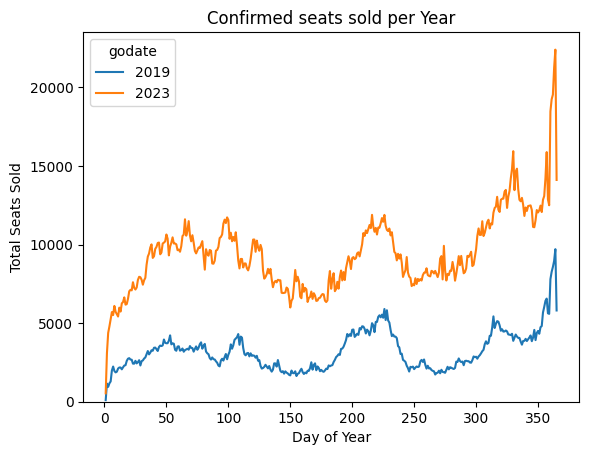

In [135]:
pivot_df = actual_travel_date_df.groupby(
    by=[actual_travel_date_df["godate"].dt.day_of_year,actual_travel_date_df["godate"].dt.year],
    )["seats"].sum().to_frame().unstack(level=1).copy()
pivot_df.columns=pivot_df.columns.levels[1]

sns.lineplot(data=pivot_df, palette="tab10", linestyle="solid", dashes=False)
plt.ylim(0)
plt.title("Confirmed seats sold per Year")
plt.xlabel("Day of Year")
plt.ylabel("Total Seats Sold")
plt.show()

Base on the chart above:
- 2023 witnessed a significant growth as the total seats sold, while at some period it is tripled compare to 2019.
- There is travel seasons. People often travel in summer (Jul & Aug), around year end and maybe after lunar new year!
- Travel trend seem to be started around 1.5 month before peaked, peak time lasted depends on which season that is.

<Figure size 1400x1500 with 0 Axes>

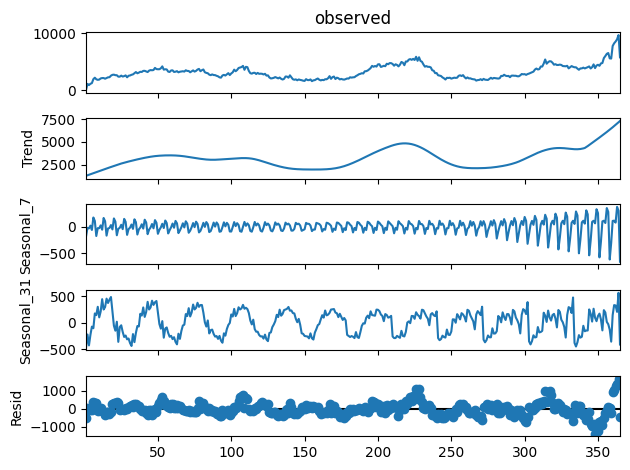

In [147]:
plt.figure(figsize=(14, 15))
mstl_2019 = MSTL(pivot_df[2019], periods=[7,31],windows=[31,61],stl_kwargs={
    "seasonal_deg":1
})
res_mstl_2019 = mstl_2019.fit()

fig = res_mstl_2019.plot()
plt.show()

<Figure size 1400x1500 with 0 Axes>

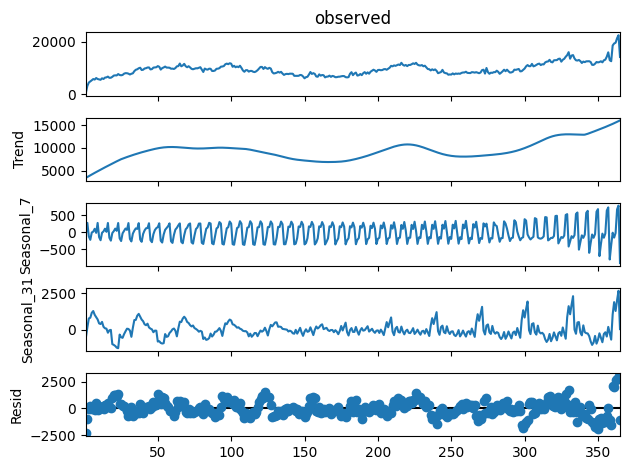

In [148]:
plt.figure(figsize=(14, 15))
mstl_2023 = MSTL(pivot_df[2023], periods=[7,31],windows=[31,61],stl_kwargs={
    "seasonal_deg":1
})
res_mstl_2023 = mstl_2023.fit()
fig = res_mstl_2023.plot()

plt.show()


The two charts above are multi season-trend decomposed plots with chosen pattern period are (7,31), calculate in a window of (31,45) days respectively. From the charts, we can deduct:
- Both "trend" decomposed lines suggesting that there're 2 main dips within a year, before and after of summer season. 
- The 7-day pattern is consistent througtout the year with +- 500 into the overall result. Both decomposed patterns suggesting that, the weekly pattern has larger affect toward the end of the year.
- 31-day pattern changed after the first haft of the year with more complex affect into overall result. Moreover, compared to 2019, monthly cycle had growth its affect to observed data. Suggesting a shift in underlying operation.
- Other then trend and seasonality, there are other drivers affecting the data due to large residuals.

### By create date

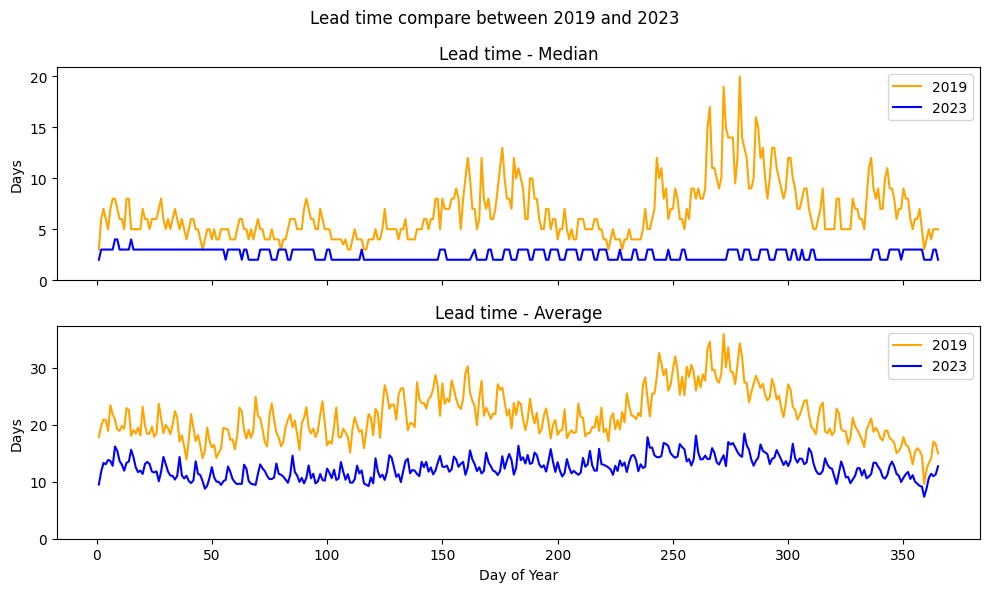

In [200]:
_pivot_df = actual_travel_df.groupby(
    [actual_travel_df["createdon"].dt.day_of_year,actual_travel_df["createdon"].dt.year])["booked_n_days_before"]\
    .agg(["mean","median"]).unstack(level=1).copy()
_pivot_df.columns = [ "_".join(map(str,t)) for t in _pivot_df.columns]

fig,ax = plt.subplots(figsize=(10, 6),nrows=2, sharex=True)

sns.lineplot(data=_pivot_df, 
            x=_pivot_df.index,
            y="median_2019", ax=ax[0], color="orange",label="2019")

sns.lineplot(data=_pivot_df, 
            x=_pivot_df.index,
            y="median_2023", ax=ax[0], color="blue",label="2023")
ax[0].set_ylim(0)
ax[0].set_title("Lead time - Median")
ax[0].set_xlabel("Day of Year")
ax[0].set_ylabel("Days")

sns.lineplot(data=_pivot_df, 
            x=_pivot_df.index,
            y="mean_2019", ax=ax[1], color="orange",label="2019")

sns.lineplot(data=_pivot_df, 
            x=_pivot_df.index,
            y="mean_2023", ax=ax[1], color="blue",label="2023")
ax[1].set_ylim(0)
ax[1].set_title("Lead time - Average")
ax[1].set_xlabel("Day of Year")
ax[1].set_ylabel("Days")

plt.suptitle("Lead time compare between 2019 and 2023")
plt.tight_layout()
plt.show()

Compare to 2019, the mean and median of lead time has reduced significantly.

In [187]:
_pivot_df.head()

,mean_2019,mean_2023,median_2019,median_2023
createdon,,,,
1,17.854064,9.512542,3.0,2.0
2,19.837808,11.753498,6.0,3.0
3,20.961844,13.305401,7.0,3.0
4,20.831111,13.076735,6.0,3.0
5,18.940997,13.832694,5.0,3.0


## Profitability

Due to financial total discrepancy issue, I'll examine both case (stored value and calculated value).

### By route

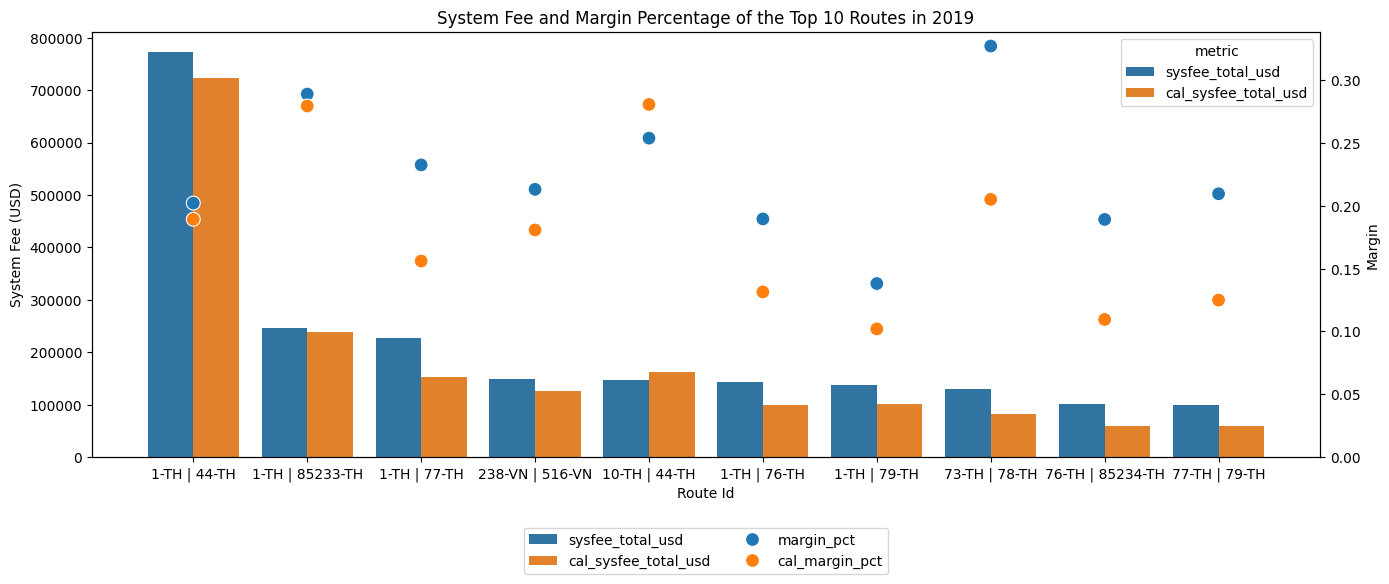

In [151]:
fig, ax = plt.subplots(figsize=(14, 6))

_pivot_df = actual_travel_df[actual_travel_df["createdon"].dt.year==2019].groupby(['route_id'])[['sysfee_total_usd','cal_sysfee_total_usd','total_usd','cal_total_usd']] \
    .agg('sum') \
    .sort_values(by='sysfee_total_usd',ascending=False).head(10).copy()

_pivot_df['margin_pct'] = _pivot_df['sysfee_total_usd'] / _pivot_df['total_usd']
_pivot_df['cal_margin_pct'] = _pivot_df['cal_sysfee_total_usd'] / _pivot_df['cal_total_usd']

sns.barplot(
    data=pd.melt(
        _pivot_df.reset_index(),id_vars='route_id',
        value_vars=['sysfee_total_usd','cal_sysfee_total_usd'],
        var_name='metric',value_name='value'
        ), 
    x='route_id', y='value',
    palette="tab10", hue = 'metric',
    ax=ax,
    )

ax1 = ax.twinx()

sns.scatterplot(
    data=pd.melt(
        _pivot_df.reset_index(),id_vars='route_id',
        value_vars=['margin_pct','cal_margin_pct'],
        var_name='metric',value_name='value'
        ),
    x='route_id', y='value',
    palette="tab10", hue = 'metric',
    ax=ax1,
    s=100,    
)
ax1.set_ylim(0)
handles, labels = ax.get_legend_handles_labels()
handles1, labels1 = ax1.get_legend_handles_labels()

plt.legend(handles=handles+handles1, labels=labels+labels1, 
          loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.title("System Fee and Margin Percentage of the Top 10 Routes in 2019")
ax.set_xlabel("Route Id")
ax.set_ylabel("System Fee (USD)")
ax1.set_ylabel("Margin")
plt.tight_layout()
plt.show()

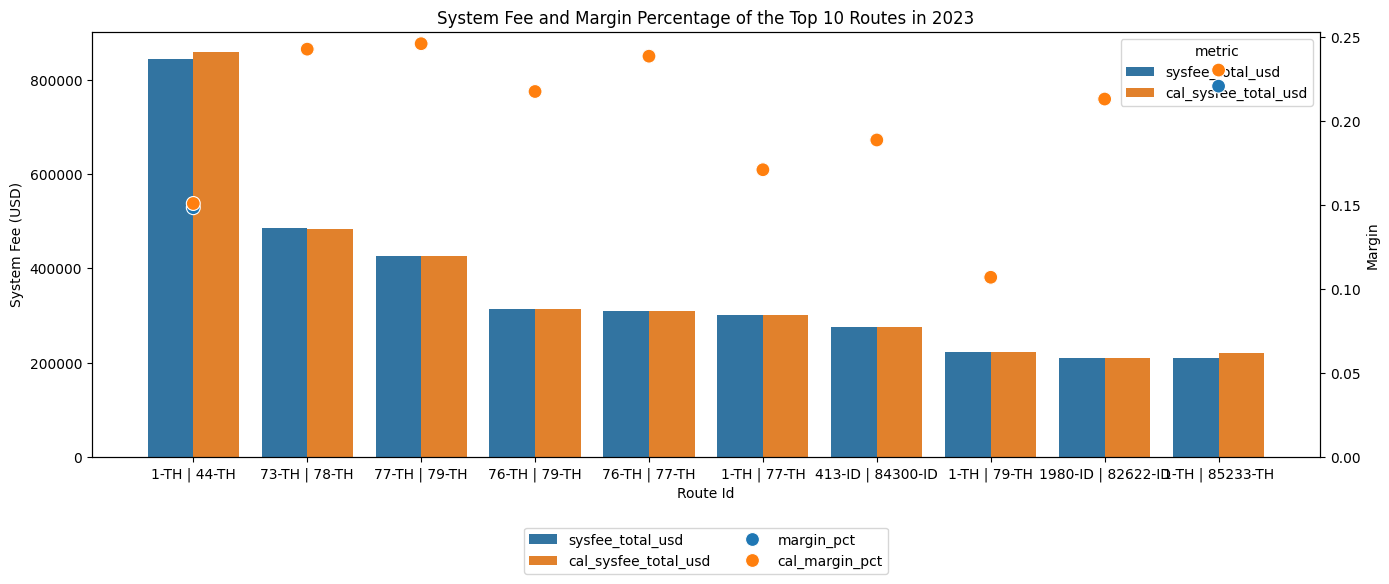

In [152]:
fig, ax = plt.subplots(figsize=(14, 6))

_pivot_df = actual_travel_df[actual_travel_df["createdon"].dt.year==2023].groupby(['route_id'])[['sysfee_total_usd','cal_sysfee_total_usd','total_usd','cal_total_usd']] \
    .agg('sum') \
    .sort_values(by='sysfee_total_usd',ascending=False).head(10).copy()

_pivot_df['margin_pct'] = _pivot_df['sysfee_total_usd'] / _pivot_df['total_usd']
_pivot_df['cal_margin_pct'] = _pivot_df['cal_sysfee_total_usd'] / _pivot_df['cal_total_usd']

sns.barplot(
    data=pd.melt(
        _pivot_df.reset_index(),id_vars='route_id',
        value_vars=['sysfee_total_usd','cal_sysfee_total_usd'],
        var_name='metric',value_name='value'
        ), 
    x='route_id', y='value',
    palette="tab10", hue = 'metric',
    ax=ax,
    )

ax1 = ax.twinx()

sns.scatterplot(
    data=pd.melt(
        _pivot_df.reset_index(),id_vars='route_id',
        value_vars=['margin_pct','cal_margin_pct'],
        var_name='metric',value_name='value'
        ),
    x='route_id', y='value',
    palette="tab10", hue = 'metric',
    ax=ax1,
    s=100,    
)
ax1.set_ylim(0)
handles, labels = ax.get_legend_handles_labels()
handles1, labels1 = ax1.get_legend_handles_labels()

plt.legend(handles=handles+handles1, labels=labels+labels1, 
          loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.title("System Fee and Margin Percentage of the Top 10 Routes in 2023")
ax.set_xlabel("Route Id")
ax.set_ylabel("System Fee (USD)")
ax1.set_ylabel("Margin")
plt.tight_layout()
plt.show()

Compare above two charts:
- "1-TH | 44-TH" remains the top revenue generator. "1-TH | 85233-TH" dropped from second place in 2019 to last in 2023. New routes like "73-TH | 78-TH" and "77-TH | 79-TH" have climbed the ranks.
- The revenue gap between "1-TH | 44-TH" and other routes narrowed. While remaining top, "1-TH | 44-TH" didn't growth as much as "73-TH | 78-TH" and "77-TH | 79-TH" in term of volume.
- The margin generally dropped for most routes, except for "emerging" routes. Which support the idea of these now are the change in travel preference compare to 2019.
- The different between calculated and stored value has been narrowed in 2023, meaning there's efforts or changes in process of storing data.

### By booking channel

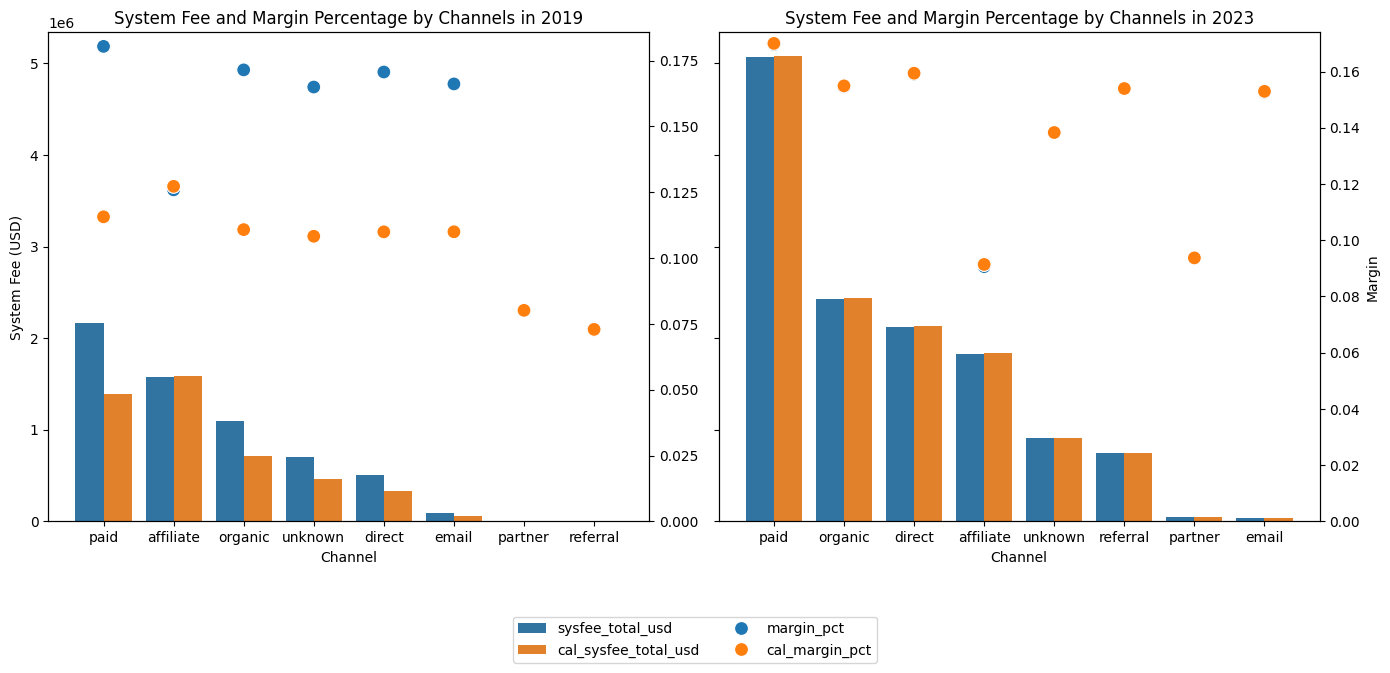

In [8]:
fig, ax = plt.subplots(figsize=(14, 6),ncols=2, sharey=True)

_pivot_df = actual_travel_df[actual_travel_df["createdon"].dt.year==2019].groupby(['channel'])[['sysfee_total_usd','cal_sysfee_total_usd','total_usd','cal_total_usd']] \
    .agg('sum') \
    .sort_values(by='sysfee_total_usd',ascending=False).copy()

_pivot_df['margin_pct'] = _pivot_df['sysfee_total_usd'] / _pivot_df['total_usd']
_pivot_df['cal_margin_pct'] = _pivot_df['cal_sysfee_total_usd'] / _pivot_df['cal_total_usd']

sns.barplot(
    data=pd.melt(
        _pivot_df.reset_index(),id_vars='channel',
        value_vars=['sysfee_total_usd','cal_sysfee_total_usd'],
        var_name='metric',value_name='value'
        ), 
    x='channel', y='value',
    palette="tab10", hue = 'metric',
    ax=ax[0],
    legend=False
    )

ax01 = ax[0].twinx()

sns.scatterplot(
    data=pd.melt(
        _pivot_df.reset_index(),id_vars='channel',
        value_vars=['margin_pct','cal_margin_pct'],
        var_name='metric',value_name='value'
        ),
    x='channel', y='value',
    palette="tab10", hue = 'metric',
    ax=ax01,
    s=100,
    legend=False
)
ax01.set_ylim(0)

_pivot_df = actual_travel_df[actual_travel_df["createdon"].dt.year==2023].groupby(['channel'])[['sysfee_total_usd','cal_sysfee_total_usd','total_usd','cal_total_usd']] \
    .agg('sum') \
    .sort_values(by='sysfee_total_usd',ascending=False).copy()

_pivot_df['margin_pct'] = _pivot_df['sysfee_total_usd'] / _pivot_df['total_usd']
_pivot_df['cal_margin_pct'] = _pivot_df['cal_sysfee_total_usd'] / _pivot_df['cal_total_usd']

sns.barplot(
    data=pd.melt(
        _pivot_df.reset_index(),id_vars='channel',
        value_vars=['sysfee_total_usd','cal_sysfee_total_usd'],
        var_name='metric',value_name='value'
        ), 
    x='channel', y='value',
    palette="tab10", hue = 'metric',
    ax=ax[1],
    )

ax11 = ax[1].twinx()

sns.scatterplot(
    data=pd.melt(
        _pivot_df.reset_index(),id_vars='channel',
        value_vars=['margin_pct','cal_margin_pct'],
        var_name='metric',value_name='value'
        ),
    x='channel', y='value',
    palette="tab10", hue = 'metric',
    ax=ax11,
    s=100,
)
ax11.set_ylim(0)

handles, labels = ax[1].get_legend_handles_labels()
handles1, labels1 = ax11.get_legend_handles_labels()
ax[1].legend_.remove()
ax11.legend_.remove()
fig.legend(handles=handles+handles1, labels=labels+labels1, 
          loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

ax[0].set_xlabel("Channel")
ax[1].set_xlabel("Channel")
ax[0].set_ylabel("System Fee (USD)")
ax[1].set_ylabel("")
ax01.set_ylabel("")
ax11.set_ylabel("Margin")

ax[0].set_title("System Fee and Margin Percentage by Channels in 2019")
ax[1].set_title("System Fee and Margin Percentage by Channels in 2023")


plt.tight_layout()
plt.show()

In [153]:
actual_travel_df \
    .groupby([actual_travel_df['createdon'].dt.year,actual_travel_df['channel']])['cal_sysfee_total_usd'] \
    .sum().unstack(level=0).sort_values(by=2023,ascending=False).head(10) 

createdon,2019,2023
channel,,
paid,1.390328e+06,5.086704e+06
organic,7.093233e+05,2.438074e+06
direct,3.276629e+05,2.131924e+06
affiliate,1.588165e+06,1.844105e+06
unknown,NaN,9.105454e+05
referral,2.820000e+00,7.444256e+05
partner,1.010658e+04,5.356428e+04
email,5.865819e+04,3.813848e+04
,4.646876e+05,1.390000e+01


- Top growing channels, in term of volume are Paid, Organic, Direct, Affiliate, Referral
- Paid remaining the highest revenue generator channel and has widen its gap compare to other channel in 2023.
- Affiliate dropped its rank to organic and direct channel and the marginal, suggesting the affiliate market has been saturated.

### By booking preferences

/var/folders/qb/p546bgx94lb0p2kdgxrnqzvw0000gn/T/ipykernel_43804/2589553488.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='center')


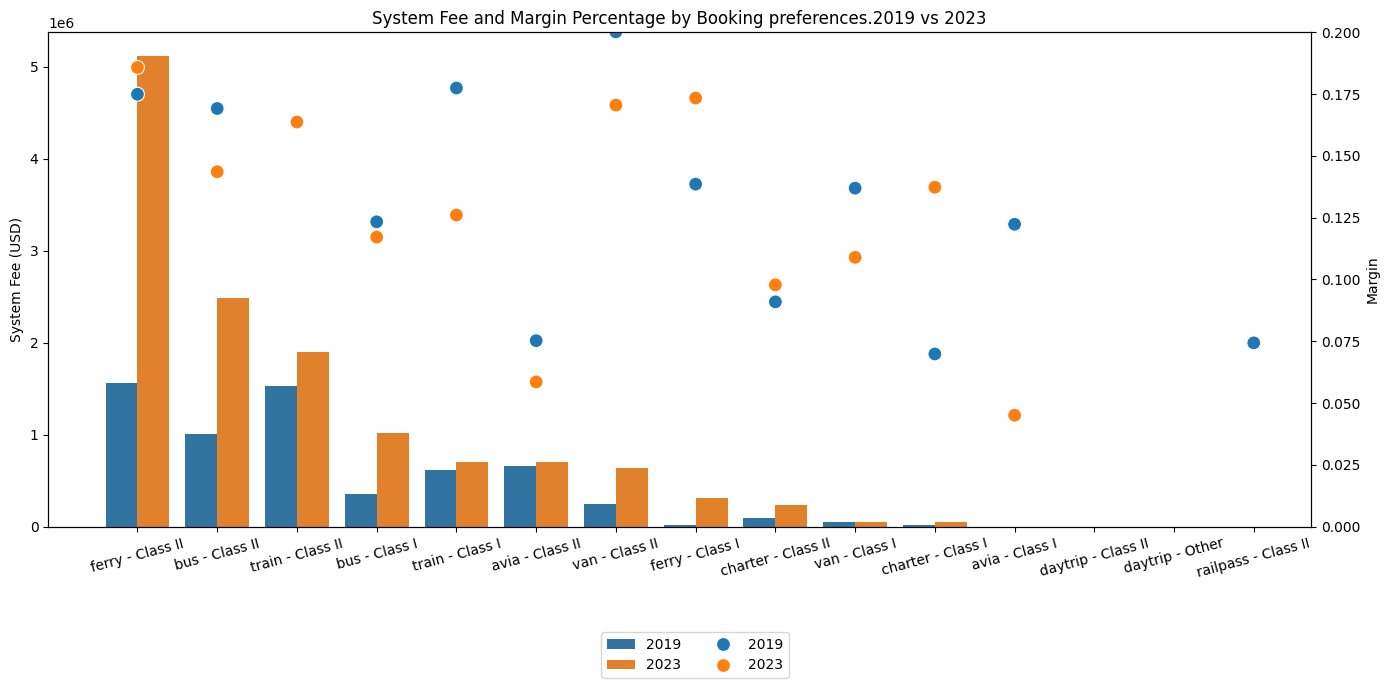

In [176]:
fig, ax = plt.subplots(figsize=(14, 6), sharey=True)

_data = actual_travel_df.groupby(['vehclass_id','class_type',actual_travel_df['createdon'].dt.year])[['sysfee_total_usd','cal_sysfee_total_usd','total_usd','cal_total_usd']] \
    .agg('sum') \
    .sort_values(by='sysfee_total_usd',ascending=False).reset_index().copy()
_data["vehicle_class"] = _data.apply(lambda x: x["vehclass_id"] + " - " + x["class_type"], axis=1)

_data['margin_pct'] = _data['sysfee_total_usd'] / _data['total_usd']
_data['cal_margin_pct'] = _data['cal_sysfee_total_usd'] / _data['cal_total_usd']

sns.barplot(
    data=_data, 
    x='vehicle_class', y='sysfee_total_usd',
    palette="tab10", hue = 'createdon',
    ax=ax,
    )

ax01 = ax.twinx()

sns.scatterplot(
    data=_data,
    x='vehicle_class', y='margin_pct',
    palette="tab10", hue = 'createdon',
    ax=ax01,
    s=100,
)
ax01.set_ylim(0,0.2)

handles, labels = ax.get_legend_handles_labels()
handles1, labels1 = ax01.get_legend_handles_labels()

ax.legend_.remove()
ax01.legend_.remove()
fig.legend(handles=handles+handles1, labels=labels+labels1, 
          loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='center')
ax.set_ylabel("System Fee (USD)")
ax01.set_ylabel("Margin")

ax.set_title("System Fee and Margin Percentage by Booking preferences.2019 vs 2023")

plt.tight_layout()
plt.show()

- Revenue dominant by Class II (standard or below) option.
- Class II ferry consistently a top option for user, and is the only has improved its margin in the top options, compare to 2019.
- While remaining among top revenue generators, train has loss its rank due to low growth rate compare to class II bus and ferry.
- Bus, regardless of Class type, has grown significantly compare to 2019.

### By user origin

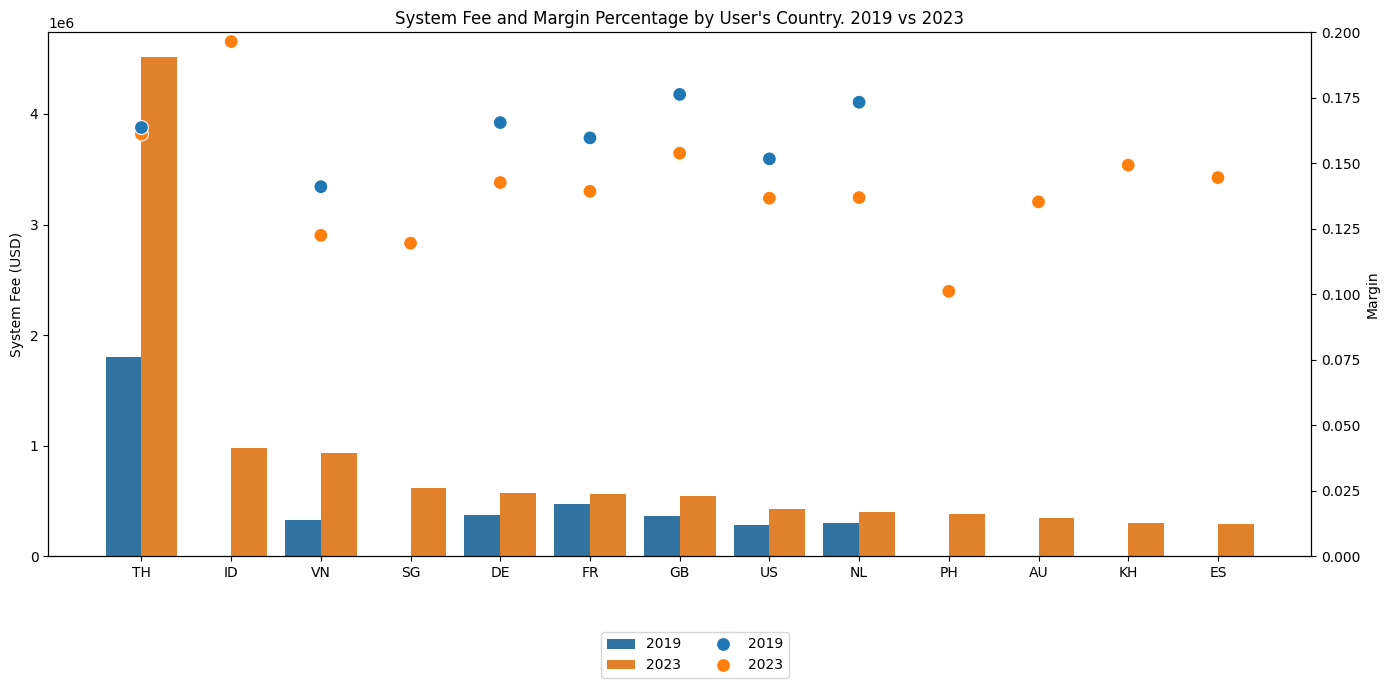

In [175]:
fig, ax = plt.subplots(figsize=(14, 6), sharey=True)

_data = actual_travel_df.groupby(['user_origin_country_id',actual_travel_df['createdon'].dt.year])[['sysfee_total_usd','cal_sysfee_total_usd','total_usd','cal_total_usd']] \
    .agg('sum') \
    .sort_values(by='sysfee_total_usd',ascending=False).reset_index().head(20).copy()

_data['margin_pct'] = _data['sysfee_total_usd'] / _data['total_usd']
_data['cal_margin_pct'] = _data['cal_sysfee_total_usd'] / _data['cal_total_usd']

sns.barplot(
    data=_data,
    x='user_origin_country_id', y='sysfee_total_usd',
    palette="tab10", hue = 'createdon',
    ax=ax,
    )

ax01 = ax.twinx()

sns.scatterplot(
    data=_data,
    x='user_origin_country_id', y='margin_pct',
    palette="tab10", hue = 'createdon',
    ax=ax01,
    s=100,
)
ax01.set_ylim(0,0.2)

handles, labels = ax.get_legend_handles_labels()
handles1, labels1 = ax01.get_legend_handles_labels()

ax.legend_.remove()
ax01.legend_.remove()
fig.legend(handles=handles+handles1, labels=labels+labels1, 
          loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

ax.set_xlabel("")
ax.set_ylabel("System Fee (USD)")
ax01.set_ylabel("Margin")

ax.set_title("System Fee and Margin Percentage by User's Country. 2019 vs 2023")

plt.tight_layout()
plt.show()

- Thailand dominant in term of revenue, however, the gap has been narrowed compare to 2019.
- There're new markets, showing expansion, mainly across APAC region (ID,SG,PH)
- Western markets (DE,FR,GB,US) are potential with high margin, compare to most of APAC markets. However, taken into account that actual revenue only slightly incress while margin dropped supporting that price was not a top driver to customer decision within that region.

### By customer type

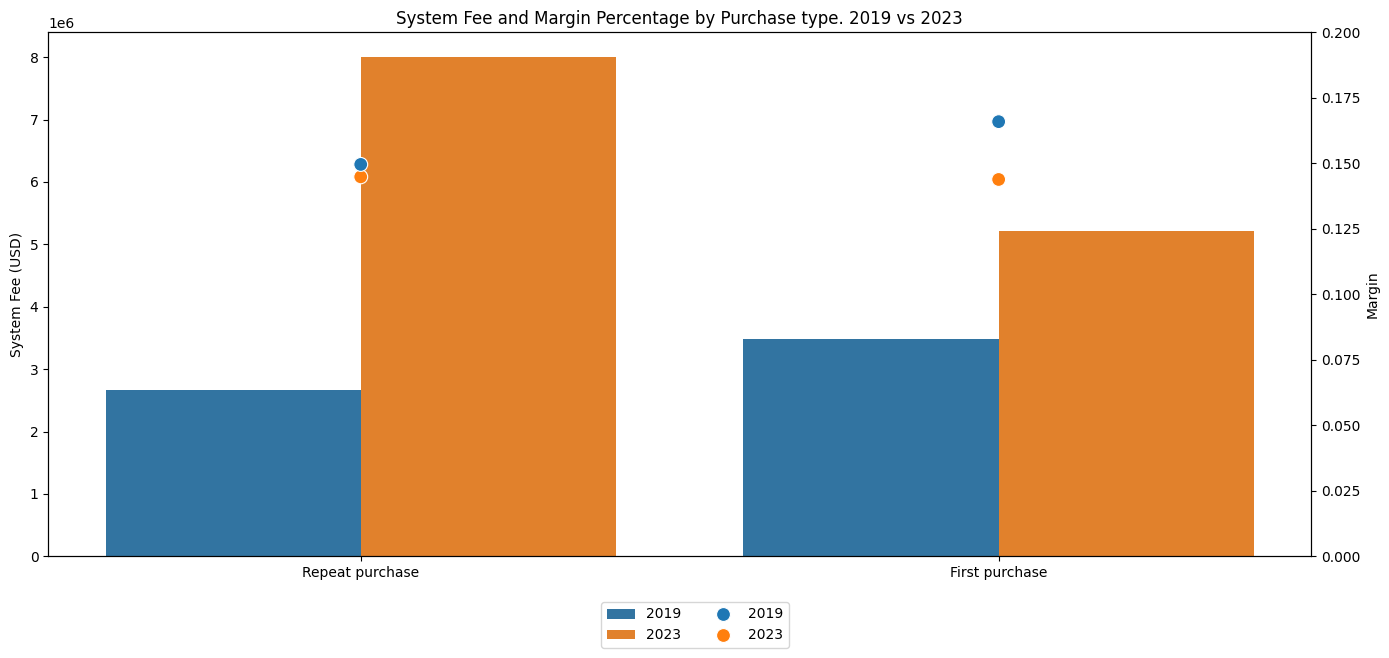

: 

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), sharey=True)

_data = actual_travel_df.groupby(['purchase_type',actual_travel_df['createdon'].dt.year])[['sysfee_total_usd','cal_sysfee_total_usd','total_usd','cal_total_usd']] \
    .agg('sum') \
    .sort_values(by='sysfee_total_usd',ascending=False).reset_index().head(20).copy()

_data['margin_pct'] = _data['sysfee_total_usd'] / _data['total_usd']
_data['cal_margin_pct'] = _data['cal_sysfee_total_usd'] / _data['cal_total_usd']

sns.barplot(
    data=_data,
    x='purchase_type', y='sysfee_total_usd',
    palette="tab10", hue = 'createdon',
    ax=ax,
    )

ax01 = ax.twinx()

sns.scatterplot(
    data=_data,
    x='purchase_type', y='margin_pct',
    palette="tab10", hue = 'createdon',
    ax=ax01,
    s=100,
)
ax01.set_ylim(0,0.2)

handles, labels = ax.get_legend_handles_labels()
handles1, labels1 = ax01.get_legend_handles_labels()

ax.legend_.remove()
ax01.legend_.remove()
fig.legend(handles=handles+handles1, labels=labels+labels1, 
          loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)

ax.set_xlabel("")
ax.set_ylabel("System Fee (USD)")
ax01.set_ylabel("Margin")

ax.set_title("System Fee and Margin Percentage by Purchase type. 2019 vs 2023")

plt.tight_layout()
plt.show()

# Summary

The analysis added some key findings:
1. Features
    - Significant growth in 2023 compare to 2019 with shorter lead time. The result might correlated with Covid19 as 2023 is more stable in overall.
    - Weekly and Monthly patterns exist and contribute to overall results, supporting summer season around Jul and Aug, Year-End
    - Overall margin decrease compare to 2019.
    - New opperating markets
2. Forming Key metrics
    - Northstar metric: Total confirmed seats sold
    - Supporting metrics: 
        - Market activity: Total bookings, Seats per booking
        - Profitability: Average profit per seat, Average booking value
        - Acquisition: Bookings by channel/Customer type, Margin by channel/Customer type
        - Service: Bookings by route/vehicle/class, Margin by route/vehicle/class
        - Operational: Refund rate & Canceled rate (Omit from further analysis as this analysis should include reason for better insights)

        ![Metrics](./images/Metrics%20framework.jpeg)
    
    - Reasoning:
        1. North star metric: directly reflect the volume booked using 12go, an indicator for business growth or downfall. The metric easily depict the financial through the total profit is the product of all seats booked and profit per seat. It is measurable and actionable as efforts can be made to improve the metric.
        2. Supporting metrics:
            - The north star metric largely depends on Market activity as it is the product of total bookings and seats per bookings (Image). While total bookings showing the volume going through the platform, seats per booking show the group size, meaning the trend or style of traveling.
            - Average profit per seat is an important metric adding to total profit. It is actionable and controlable (in percentage) through dealing with suppliers.
            - Both Market activity and Avg profit per seat affected by the resource put in the market, including acquisition performance, user retention and service offered. Therefore, it must be controled in drilldown analysis.